# Processamento de Linguagem Natural (NLP)

Professor: Arlindo Galvão

Data: 09/09/2024

## Cronograma

* Implemente diversos tipos de atenção

### **Implementando RNN Seq2Seq sem atenção**

In [301]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import random

**Teremos 4 classes principais:**
- **Tokenizer:** mapeia nosso input textual para o input do modelo;
- **Encoder:** realiza o encoding do input;
- **Decoder:** realiza a decodificação a partir do hidden state anterior (com a possibilidade de attention);
- **Seq2seq:** encapsula nosso Encoder e nosso Decoder, e transforma do espaço latente para o token id.

**Tokenizer:** Aqui que iremos trabalhar com nossos dados de entrada. Todos os tratamentos iremos fazer por meio desta classe.

In [302]:
class Tokenizer():
    def __init__(self):
        self.tokens_special = ["<sos>", "<eos>", "<oov>",]
        self.vocab_input = self.tokens_special[:]
        self.vocab_output = self.tokens_special[:]
        self.len_vocab_input = len(self.vocab_input)
        self.len_vocab_output = len(self.vocab_output)

        self.SOS_ID = self.tokens_special.index("<sos>") # start of sentence
        self.EOS_ID = self.tokens_special.index("<eos>") # end of sentence
        self.OOV_ID = self.tokens_special.index("<oov>") # out of vocabulary


    def add_input_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_input:
                self.vocab_input.append(token)
        self.len_vocab_input = len(self.vocab_input)


    def add_output_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_output:
                self.vocab_output.append(token)
        self.len_vocab_output = len(self.vocab_output)


    def tokens2inputs_id(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()

        inputs_id = [self.SOS_ID]

        for token in tokens:
            if token in self.vocab_input:
                inputs_id.append(self.vocab_input.index(token))
            else:
                inputs_id.append(self.OOV_ID)
        return torch.tensor(inputs_id)


    def tokens2outputs_id(self, tokens):
        outputs_id = []
        for token in tokens:
            if token in self.vocab_output:
                outputs_id.append(self.vocab_output.index(token))
            else:
                outputs_id.append(self.OOV_ID)
        outputs_id.append(self.EOS_ID)
        return torch.tensor(outputs_id)


    def outputs_id2text(self, outputs_id):
        if type(outputs_id) == int:
            outputs_id = [outputs_id]
        text = ""
        for id in outputs_id:
            text += self.vocab_output[id]
        return text

**Encoder:** Aqui que ocorrerá o processamento do nosso input.

In [303]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

**Decoder:** A partir das representações geradas pelo Encoder, nós iremos gerar nosso output utilizando esta classe.

> OBS: Ao utilizar esta classe com use_attention=True, estamos concatenando o attention ao embedding do token, e não ao hidden state.

In [304]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=False):
        super(Decoder, self).__init__()
        self.output_vocab_size = output_vocab_size
        self.embedding = nn.Embedding(output_vocab_size, emb_dim)
        self.use_attention = use_attention
        if self.use_attention:
            self.rnn = nn.RNN(emb_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout)
        else:
            self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, attention=None):
        embedded = self.dropout(self.embedding(input))
        if self.use_attention:
            embedded = torch.cat((embedded, attention), dim=1)

        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

**Seq2Seq:** Esta classe vai encapsular nosso Encoder e nosso Decoder, realizando o fluxo do nosso modelo. Também é nela que ocorrerá a linear + softmax para obter a distribuição de probabilidade de tokens.

In [305]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state)
        output = self.fc_out(output)
        output_distribution = F.softmax(output, dim=1)
        return output_distribution, hidden

Agora, vamos configurar e utilizar nosso modelo

In [306]:
EMB_DIM = 16
HIDDEN_DIM = 16
N_LAYERS = 1
DROPOUT = 0.0
MAX_STEPS = 10

tokenizer = Tokenizer()
inputs = ["a", "b", "c", "d"]
outputs = ["1", "2", "3", "4"]
tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [307]:
model = Seq2Seq(tokenizer.len_vocab_input, tokenizer.len_vocab_output, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
# Vamos printar nossa arquitetura, veremos que possui um encoder, um decoder e uma linear ao final
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7, 16)
    (rnn): RNN(16, 16)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7, 16)
    (rnn): RNN(16, 16)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (fc_out): Linear(in_features=16, out_features=7, bias=True)
)


In [308]:
input = "a b c d"
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {input}")
print(f"Saída: {tokenizer.outputs_id2text(outputs_ids)}")

Entrada: a b c d
Saída: <oov><sos><eos>


Como nosso modelo ainda não foi treinado, é esperado que sua saída seja aleatória. Como não removemos nenhum token especial, também é possível que sua saída possua tokens especiais (como o token \<sos\> em posições além do começo da sentença).

#### **IMPLEMENTANDO O TREINAMENTO**

Abaixo está o código que realiza o treinamento do modelo. Neste exemplo, estamos mapeando modelo para traduzir cada letra para seu correspondente numérico (a:1, b:2, c:3, d:4, e:5)


Ex.
> Input: ["a", "b", "c", "d", "e"]<br>
> Output: "1 2 3 4 5"

In [309]:
# Instanciando o Tokenizer
tokenizer = Tokenizer()

# Adiciona as letras ao vocabulário do Tokenizer
inputs = ["a", "b", "c", "d", "e"]
outputs = [str(i+1) for i, _ in enumerate(inputs)] # Mapeando letras para números como strings

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

def get_random_sample():
    num_char_input = np.random.randint(1,4) # vamos escolher aleatoriamente entre 1 e 3 char para input (pode ser a, ab, abc)
    sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input) # vamos escolher nossos caracteres aleatoriamente, mas sem escolher tokens especiais
    sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
    sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
    return sampled_inputs, sampled_outputs  # Repare que o join do input nao tem espaço e o do output tem, pois vamos querer que ele gere também os espaços.

In [310]:
# Definir parâmetros
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

# Instanciar o modelo
model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [311]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Função de treino
def train(model, tokenizer, criterion, optimizer, num_steps):
    history = {'total_steps': 0, 'loss': []}
    model.train()

    for step in range(num_steps):
        optimizer.zero_grad()

        # Exemplo de entrada e saída
        input_text, output_text = get_random_sample()

        # Converte o texto de entrada e saída para IDs
        inputs_id = tokenizer.tokens2inputs_id(input_text)
        output_target_id = tokenizer.tokens2outputs_id(output_text)
        input_id_decoder = torch.tensor([tokenizer.SOS_ID])

        # Forward pass
        loss = 0
        decoder_hidden_state = None
        for target_id in output_target_id:
            output_distribution, decoder_hidden_state = model(inputs_id_encoder=inputs_id,
                                                              input_id_decoder=input_id_decoder,
                                                              decoder_hidden_state=decoder_hidden_state)

            result_tensor = torch.zeros(tokenizer.len_vocab_output, dtype=torch.float)
            result_tensor[target_id] = 1

            # Calcula a perda, Cross Entropy entre predições e targets (precisamos do unsqueeze para adicionar a dimensão do batch no nosso result_tensor)
            loss += criterion(output_distribution, result_tensor.unsqueeze(0))

            # O próximo input do decoder será o token gerado pelo decoder atual
            input_id_decoder = torch.argmax(output_distribution, dim=1)

        # Salvando o historico de informações sobre o treinamento
        history['loss'].append(loss.item())
        history['total_steps'] += 1

        # Backpropagation
        loss.backward()
        optimizer.step()

        if step % 250 == 0:
            print(f'Epoch {step}/{num_steps}, Loss: {loss.item():.4f}')
    return history

# Treinar o modelo
history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 4.1932
Epoch 250/5000, Loss: 5.2777
Epoch 500/5000, Loss: 6.8458
Epoch 750/5000, Loss: 3.3876
Epoch 1000/5000, Loss: 4.6963
Epoch 1250/5000, Loss: 6.2044
Epoch 1500/5000, Loss: 2.5653
Epoch 1750/5000, Loss: 2.5615
Epoch 2000/5000, Loss: 4.4274
Epoch 2250/5000, Loss: 3.9338
Epoch 2500/5000, Loss: 4.4904
Epoch 2750/5000, Loss: 6.6832
Epoch 3000/5000, Loss: 6.5952
Epoch 3250/5000, Loss: 5.2471
Epoch 3500/5000, Loss: 2.5628
Epoch 3750/5000, Loss: 6.1015
Epoch 4000/5000, Loss: 3.8540
Epoch 4250/5000, Loss: 2.5496
Epoch 4500/5000, Loss: 3.8283
Epoch 4750/5000, Loss: 2.5524


In [312]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    # Vamos fazer uma média para tentar lidar melhor com outliers (loss muito alta em meio à losses baixar ou vice-versa)
    mean_steps = 20
    mean_loss_n_steps = [sum(history['loss'][i:i+mean_steps])/mean_steps for i in range(0,history['total_steps'],mean_steps)]
    plt.plot(list(range(0,history['total_steps'],mean_steps)), mean_loss_n_steps)

    plt.title('Loss Curve')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

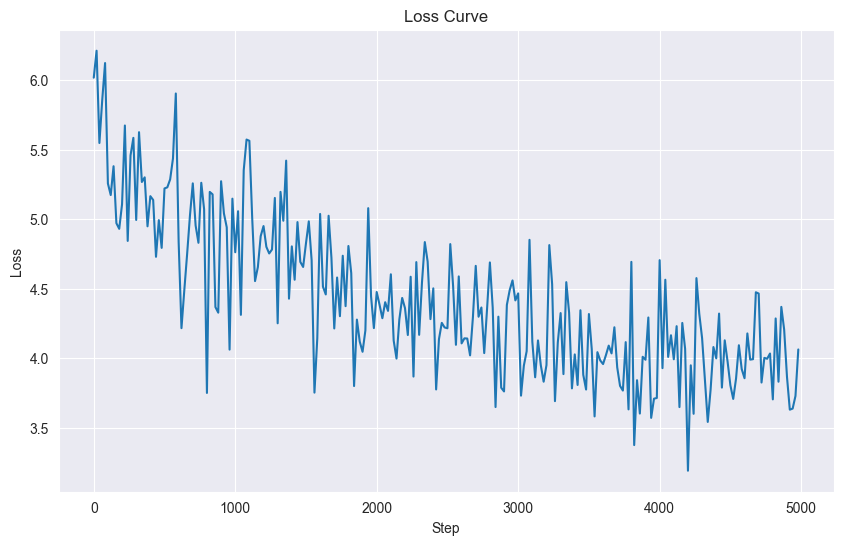

In [313]:
plot_loss(history)

Testando com inputs:

In [314]:
input = ["a", "c"]
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {' - '.join(input)}")
print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

Entrada: a - c
Saída: 1 - 3 - <eos>


Parece que nosso modelo aprendeu algo :)

#### **Teste!**
Brinque com os parâmetros, dados de input e output, e teste o modelo. Entenda o que está acontecendo.

Exemplo: Como ele se comportaria caso tentassemos fazer com todo o alfabeto? E se mudassemos a quantidade máxima de tokens que o encoder é treinado?

1º Teste: Adicionar algumas letras ao alfabeto

In [315]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

def get_random_sample():
    num_char_input = np.random.randint(1,4)
    sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input)
    sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
    sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
    return sampled_inputs, sampled_outputs

In [316]:
sampled_inputs, sampled_outputs = get_random_sample()

In [317]:
sampled_inputs, sampled_outputs

(['e', 'k', 'h'], ['5', '11', '8'])

In [318]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 64
hidden_dim = 128
n_layers = 4
dropout = 0.2
learning_rate = 0.0001
num_steps = 50000

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [319]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/50000, Loss: 8.3250
Epoch 250/50000, Loss: 10.2421
Epoch 500/50000, Loss: 10.1749
Epoch 750/50000, Loss: 10.1808
Epoch 1000/50000, Loss: 4.5693
Epoch 1250/50000, Loss: 4.6243
Epoch 1500/50000, Loss: 4.6693
Epoch 1750/50000, Loss: 9.6750
Epoch 2000/50000, Loss: 9.0881
Epoch 2250/50000, Loss: 4.6558
Epoch 2500/50000, Loss: 9.6688
Epoch 2750/50000, Loss: 6.6917
Epoch 3000/50000, Loss: 9.3533
Epoch 3250/50000, Loss: 6.8257
Epoch 3500/50000, Loss: 3.8077
Epoch 3750/50000, Loss: 3.7703
Epoch 4000/50000, Loss: 6.6276
Epoch 4250/50000, Loss: 3.8369
Epoch 4500/50000, Loss: 8.6607
Epoch 4750/50000, Loss: 8.3666
Epoch 5000/50000, Loss: 4.6897
Epoch 5250/50000, Loss: 6.6477
Epoch 5500/50000, Loss: 6.4928
Epoch 5750/50000, Loss: 4.7200
Epoch 6000/50000, Loss: 6.5814
Epoch 6250/50000, Loss: 3.8291
Epoch 6500/50000, Loss: 6.5942
Epoch 6750/50000, Loss: 6.6225
Epoch 7000/50000, Loss: 8.5527
Epoch 7250/50000, Loss: 9.2163
Epoch 7500/50000, Loss: 6.1074
Epoch 7750/50000, Loss: 6.6153
Epoch 8000/

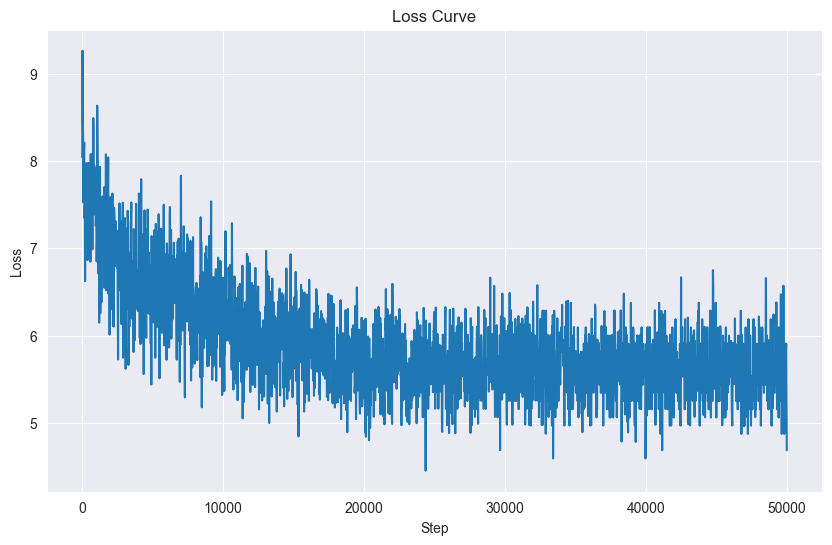

In [320]:
plot_loss(history)

In [321]:
def test_model(model, tokenizer_model, input):
    enc_inp = tokenizer_model.tokens2inputs_id(input)
    hidden_state = None
    token_id = torch.tensor([tokenizer_model.SOS_ID])
    outputs_ids = []

    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
        outputs_ids.append(token_id.item())
        if token_id.item() == tokenizer_model.EOS_ID:
            break

    print(f"Entrada: {' - '.join(input)}")
    print(f"Saída: {' - '.join([tokenizer_model.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

In [322]:
test_model(model, tokenizer, ["b", "a", "c"])

Entrada: b - a - c
Saída: 2 - 1 - 3 - <eos>


**Comentario**

Percebi que:

- Temos que reinstanciar o otimizador para que o modelo treine na célula de teste.
- Além disso, aumentar o vocabulário torna necessário aumentar o número de steps para que o modelo aprenda; para 5000 steps (como treinado no anterior) não funcionou bem.
- Outro ponto é que fizemos o modelo ser treinado com sequências de tamanho máximo igual a 3. Com isso, não otimizamos a produção de um *hidden_state* representativo para sequências maiores e, assim, se testado em uma sequência maior, dificilmente irá funcionar bem.


2º Teste: Alfabeto completo

In [323]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [324]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.7457
Epoch 250/5000, Loss: 12.5833
Epoch 500/5000, Loss: 9.1633
Epoch 750/5000, Loss: 9.1510
Epoch 1000/5000, Loss: 9.1411
Epoch 1250/5000, Loss: 5.7560
Epoch 1500/5000, Loss: 12.5235
Epoch 1750/5000, Loss: 12.5615
Epoch 2000/5000, Loss: 12.5397
Epoch 2250/5000, Loss: 9.0672
Epoch 2500/5000, Loss: 9.1390
Epoch 2750/5000, Loss: 9.2228
Epoch 3000/5000, Loss: 12.6415
Epoch 3250/5000, Loss: 12.6298
Epoch 3500/5000, Loss: 5.8333
Epoch 3750/5000, Loss: 12.6232
Epoch 4000/5000, Loss: 5.8175
Epoch 4250/5000, Loss: 11.7053
Epoch 4500/5000, Loss: 5.8257
Epoch 4750/5000, Loss: 5.8291


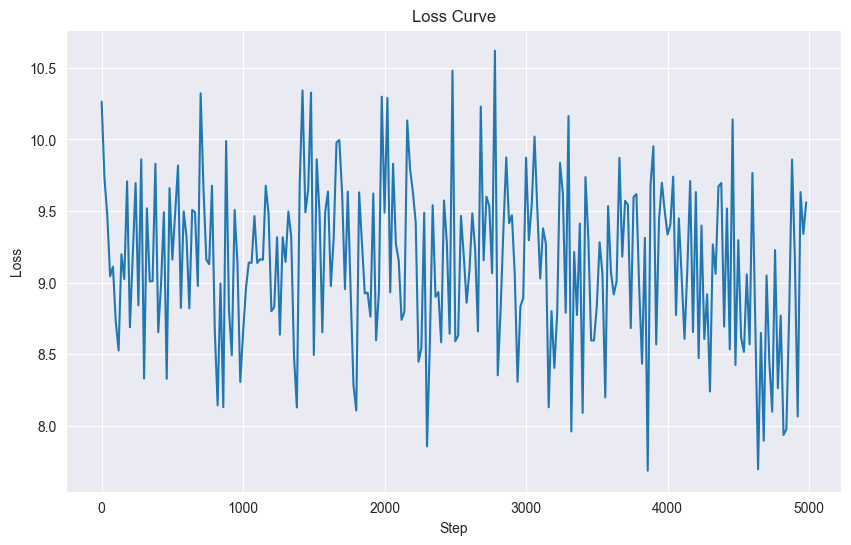

In [325]:
plot_loss(history)

In [326]:
test_model(model, tokenizer, ["n", "l", "p"])

Entrada: n - l - p
Saída: 24 - 24 - 14 - <eos>


---

## **ATIVIDADE**

#### **INSTRUÇÕES**

- **FOQUE EM ALTERAR APENAS A CLASSE Seq2Seq.** Caso necessário, faça alterações mínimas nas outras partes do código e documente a motivação. A ideia não é reestruturar o código, mas complementá-lo. <br><br>
- **DOCUMENTE SEU PASSO A PASSO POR MEIO DE CÉLULAS DE TEXTO.** Não utilize de grandes comentários no seu código. Utilize das ferramentas do markdown para fazer comentários, destacar, colar imagens, etc. para documentar seus avanços.<br><br>
- **NÃO EXCLUA OS OUTPUTS.** Ao entregar este notebook, não exclua o output final das células, mantenha os resultados, loss, gráficos e o que julgar necessário para entendimento do seu progresso.<br><br>
- **É PERMITIDO O USO DE LLM (ex: ChatGPT).** Documente seus prompts e como o modelo te ajudou (substitua grandes partes por placeholders na documentação, por exemplo, caso tenha colado a classe Seq2Seq, na documentação escreva "Prompt: por favor, me ajude a entender a seguinte classe: [Classe Seq2Seq]"). Cite como o LLM te ajudou em textos, não apenas colando a resposta por ele (ex: Com este prompt, o LLM me ajudou a entender ... e gerar a parte do código referente à ..., mas com erro em ...).

**Documente aqui quais LLMs foram utilizados:** (ex: ChatGPT)<br>

**Comentario**

Após estabelecer a linha de raciocínio do que faria para responder a primeira questão, vi que seria necessário acessar cada *hidden* do encoder e o *hidden* do decoder. Com isso, investiguei mais o código e achei as variáveis: `encoder_hidden_states`, `decoder_hidden_state`. Ao investigar, vi que minhas `encoder_hidden_states` forneciam exatamente o hidden para cada "step de tempo", cada token + hidden anterior de entrada na rede. Contudo, vi também que o hidden do decoder vinha com uma dimensão maior que a esperada (esperava um único vetor do hidden naquele timestamp), porém, vi que vinham 2, o último vetor era como o esperado, mas o primeiro não.

Usei o ChatGPT para me tirar essa dúvida:
1 - Enviei um prompt pedindo para me explicar por que desse retorno do `hidden` do decoder ter dimensão maior que 1 (passei parcela do código necessária)  
Resposta: Dentro da resposta, uma das possibilidades destacadas é que, como foram definidas 2 camadas, ele me retornava o hidden para cada camada do decoder, enquanto no encoder, era apenas o hidden final daquele timestamp.

Com isso, fiz alguns testes com o número de camadas e vi que de fato ele se comportava como descrito. Para sanar 100% da dúvida, abri a documentação no seguinte link: [https://pytorch.org/docs/stable/generated/torch.nn.RNN.html](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), e vi que realmente era isso na seguinte linha: "`h_n`: tensor de forma `(D * num_layers, H_out)` para entradas sem batch ou `(D * num_layers, N, H_out)` contendo o estado oculto final para cada elemento no batch. Como estamos sem batches, temos o shape (num_layers, H_out) (nosso D é igual a 1, pois não é bidirecional). Assim, para os cálculos da atenção consideraremos o `hidden` do decoder como o `hidden` da última camada.

Além disso, usei o chatgpt para formatar meus comentários para markdown"


REFERÊNCIAS:

https://www.youtube.com/watch?v=94hG00EJFNo&list=PLSZEVLiOtIgF19_cPrvhJC2bWn-dUh1zB&index=7

https://pt.d2l.ai/chapter_attention-mechanisms/attention-scoring-functions.html


##### **A partir das classes estabelecidas e do código de treinamento, modifique a classe Seq2Seq para responder as questões seguintes:**

#### **Questão 1**
Altere a classe Seq2Seq para implementar uma attention através da média dos hidden states do encoder (semelhante à gerar um attention score igual à todos os hidden states do encoder). Mantenha a concatenação entre o attention output e o embedding como na classe Decoder originalmente implementada. Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

**Comentario**

Para essa e as demais questões foi necessário entender que na classe `Seq2Seq`, no `forward` temos a seguinte lógica:

- **Caso não tenhamos nenhum *hidden* para o decoder naquele timestamp**, significa que não processamos o encoder ainda (entramos no `if` e processamos o encoder, salvando o *hidden* de cada "tempo" do encoder, e atribuimos como *hidden* do decoder naquele instante o último *hidden* do encoder (que de fato é a entrada do decoder no primeiro timestamp).

- **Após isso**, temos somente o decoder sendo processado (pois já processamos o encoder), e o *hidden* do decoder é passado para o próximo timestamp. Com isso, "perdemos" a informação dos *hiddens* do encoder (que são necessários para o cálculo da atenção).

Para a primeira atenção, que é um cálculo simples da média dos vetores de *hidden* do encoder, podemos calcular esse vetor médio apenas no processamento do encoder, e salvar apenas esse vetor de atenção. Contudo, nos próximos passos, essa abordagem já não é mais válida.


**Comentario**

Para o código abaixo temos as seguintes alterações:

1. Adicionamos a variável `self.attention` para armazenar a média dos *hidden states* do encoder. Como o valor do attention não depende da entrada do decoder, ele é calculado apenas na primeira chamada do `forward`. Após isso, fica guardado, claro para o processamento de uma sequência.

2. No `forward`, recebemos os `inputs_id` (tensor que representa a entrada, ou seja, a sequência de tokens de entrada), o `input_id_decoder` (tensor que representa o token de entrada do decoder) e o `decoder_hidden_state` (tensor que representa o hidden state do decoder). Se o `decoder_hidden_state` for `None`, significa que estamos no primeiro passo do decoder, então precisamos processar o encoder. Para isso, chamamos o encoder com os `inputs_id` e guardamos os `encoder_hidden_states` do encoder em `encoder_hidden_states` e o `decoder_hidden_state` final do encoder em `decoder_hidden_state`. Calculamos a média dos `encoder_hidden_states` do encoder e guardamos em `self.attention`.


**Comentario**

Na prática, o código mudou no seguinte aspecto:
1. Adicionamos a variável `self.attention` para armazenar a média dos hidden states do encoder. 
2. O vetor de atenção agora é passado ao decoder

In [486]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.attention = None #inicialização do attention
        self.attention_scores = []


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.attention = torch.mean(encoder_hidden_states, dim=0, dtype=torch.float32).unsqueeze(0) # Faz a média dos hidden do encoder 

            seq_len = encoder_hidden_states.size(0)
            self.attention_scores = torch.ones(seq_len) / seq_len  # Shape: (seq_len,)
                
            


        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=self.attention)
        output = self.fc_out(output)

        '''A FUNÇÃO SOTMAX JÁ ESTÁ PRESENTE NO CÁLCULO DA LOSS, ISSO PODE ATRAPALHAR O TREINO,
        A LINHA ABAIXO RETORNAVA O TOKEN DE MAIOR PROBABILIDADE, PORÉM, PARA O CÁLCULO DA LOSS QUEREMOS A PROBABILIDADE DE CADA TOKEN'''
        #output_distribution = F.softmax(output, dim=1) A FUNÇÃO SOTMAX JÁ ESTÁ PRESENTE NO CÁLCULO DA LOSS, ISSO PODE ATRAPALHAR O TREINO
        #token_id = torch.argmax(output_distribution, dim=1) ESSA LINHA RETORNAVA O TOKEN DE MAIOR PROBABILIDADE, PORÉM, PARA O CÁLCULO DA LOSS QUEREMOS A PROBABILIDADE DE CADA TOKEN
        
        return output, hidden

##### Alfabeto completo (modelo 1)

In [487]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [493]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=29, bias=True)
)

In [494]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.6818
Epoch 250/5000, Loss: 7.0664
Epoch 500/5000, Loss: 3.7448
Epoch 750/5000, Loss: 2.8507
Epoch 1000/5000, Loss: 9.6140
Epoch 1250/5000, Loss: 9.7168
Epoch 1500/5000, Loss: 2.0199
Epoch 1750/5000, Loss: 8.3072
Epoch 2000/5000, Loss: 7.6625
Epoch 2250/5000, Loss: 7.6234
Epoch 2500/5000, Loss: 1.7388
Epoch 2750/5000, Loss: 1.2926
Epoch 3000/5000, Loss: 10.7175
Epoch 3250/5000, Loss: 7.7082
Epoch 3500/5000, Loss: 3.8452
Epoch 3750/5000, Loss: 4.9146
Epoch 4000/5000, Loss: 0.6592
Epoch 4250/5000, Loss: 0.5327
Epoch 4500/5000, Loss: 4.9840
Epoch 4750/5000, Loss: 8.8090


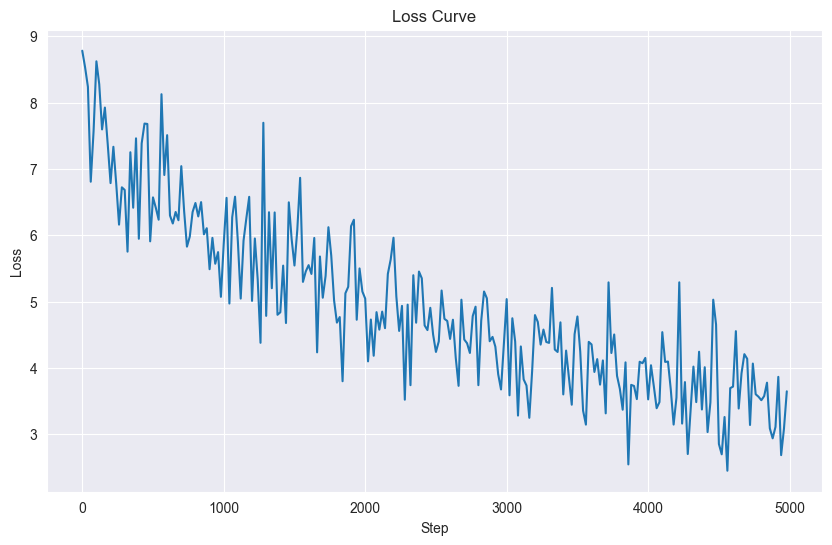

In [495]:
plot_loss(history)

In [499]:
test_model(model1, tokenizer, ["n", "l", "p"])

Entrada: n - l - p
Saída: 14 - 12 - 12 - <eos>


**Comentario**

Nesse ponto é possível perceber que, mesmo com os mesmos parâmetros da rede de teste, o modelo convergiu bem melhor, já sendo possível observar um resultado mais próximo do esperado. Uma das teorias que tenho é que isso provavelmente acontece porque adicionamos uma conexão mais "direta" entre o codificador e o decodificador, o que pode ajudar no fluxo do gradiente. Onde, a influência de uma entrada que ajuda a formar o *hidden* em um instante t, *hidden* esse que será corrigido na otimização, não está mais a n passos de distância, mas sim, diretamente ligado ao *hidden* do decoder, visto que passamos o vetor das médias diretamente para o *hidden* do instante processado no decoder. Por isso, acredito que mesmo com uma atenção bem simples, o modelo tenha convergido melhor.


Além disso, o mapa de atenção será plotado apenas uma vez na questão 1 e 2, visto que teriamos os mesmos resultados para os dois modelos em cada uma das questões, para as questões 3 e 4 plotaremos a atenção para cada modelo.

#### Alfabeto até F (modelo 2)

In [333]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [334]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=9, bias=True)
)

In [335]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 4.3078
Epoch 250/5000, Loss: 6.2094
Epoch 500/5000, Loss: 1.0301
Epoch 750/5000, Loss: 2.7203
Epoch 1000/5000, Loss: 1.4292
Epoch 1250/5000, Loss: 5.4487
Epoch 1500/5000, Loss: 4.6302
Epoch 1750/5000, Loss: 0.1767
Epoch 2000/5000, Loss: 0.2033
Epoch 2250/5000, Loss: 0.1712
Epoch 2500/5000, Loss: 0.3309
Epoch 2750/5000, Loss: 0.4534
Epoch 3000/5000, Loss: 0.5114
Epoch 3250/5000, Loss: 0.0522
Epoch 3500/5000, Loss: 0.2199
Epoch 3750/5000, Loss: 0.1303
Epoch 4000/5000, Loss: 0.0671
Epoch 4250/5000, Loss: 1.4095
Epoch 4500/5000, Loss: 0.0204
Epoch 4750/5000, Loss: 0.2548


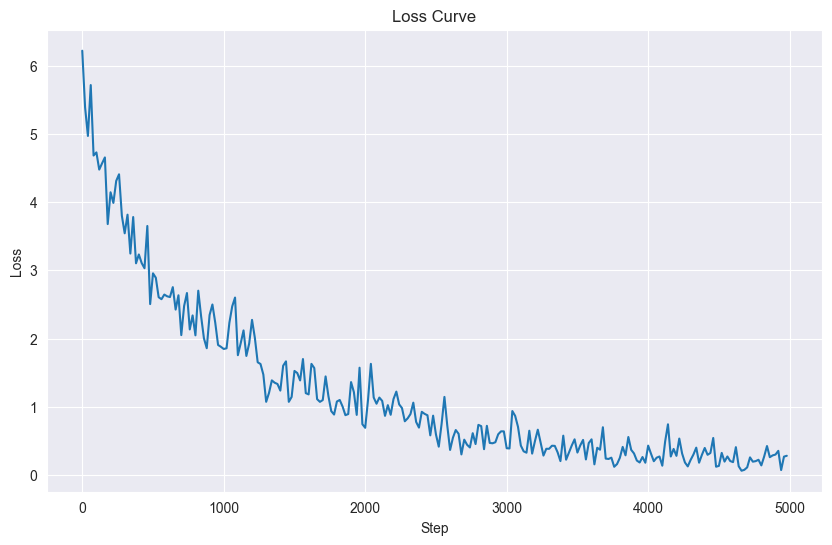

In [336]:
plot_loss(history)

In [337]:
test_model(model2, tokenizer, ["a", "b", "c"])

Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


##### **Mapa de atenção**

**Comentario**

**FUNÇÃO PLOT_ATTENTION:**

A atenção para formar a matriz é calculada da seguinte forma:

- Para todo token predito pelo `decoder`, tivemos um *hidden* anterior que gerou esse token. Possuímos também os *hiddens* do `encoder`, que são os *hiddens* de cada token de entrada. A partir disso, para cada *hidden* presente no `decoder`, é calculado o *attention score* com todos os *hiddens* do `encoder`. Com isso, temos uma matriz de atenção, onde cada linha representa um token do `decoder` e cada coluna representa um token do `encoder`. Assim, para cada token que geramos, é retornado um vetor com seus *attention scores* em relação a cada *hidden* do `encoder`.


Entrada: a - b - c
Saída: 1 - 6 - 3 - <eos>


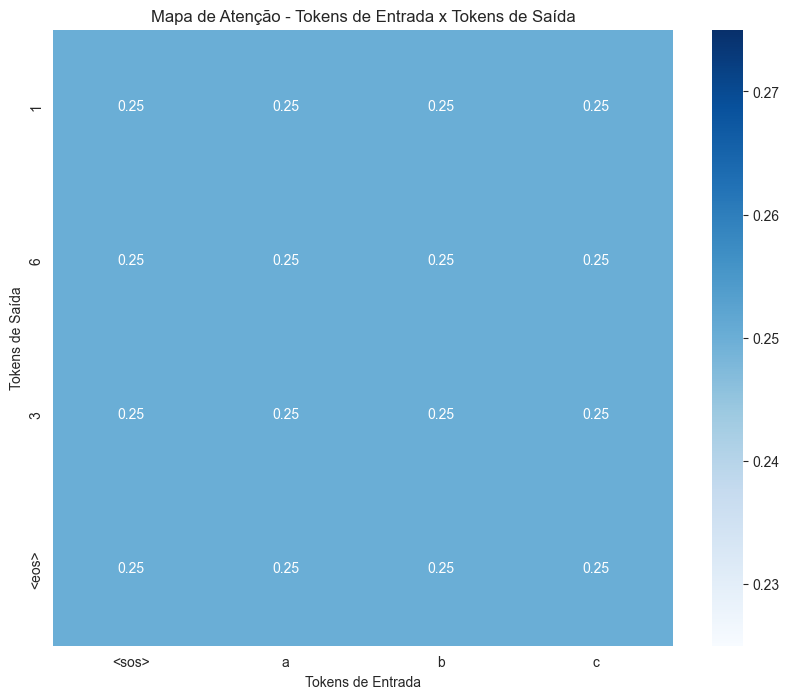

In [338]:
def plot_attention(model, tokenizer, input=["a", "b", "c"]):
    enc_inp = tokenizer.tokens2inputs_id(input)
    hidden_state = None
    token_id = torch.tensor([tokenizer.SOS_ID])
    outputs_ids = []

    attention_matrix = []
    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)
        token_id_value = token_id.item()

        if token_id_value >= len(tokenizer.vocab_output):
            token_id_value = tokenizer.OOV_ID

        outputs_ids.append(token_id_value)
        attention_matrix.append(model.attention_scores)

        if token_id_value == tokenizer.EOS_ID:
            break

    print(f"Entrada: {' - '.join(input)}")
    print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

    num_output_tokens = len(outputs_ids)
    num_input_tokens = len(enc_inp)

    attention_matrix_np = np.stack([score.detach().numpy() for score in attention_matrix])

    attention_matrix_np = attention_matrix_np[:num_output_tokens, :num_input_tokens]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        attention_matrix_np,
        annot=True,
        cmap='Blues',
        xticklabels=[tokenizer.vocab_input[i] for i in enc_inp],
        yticklabels=[tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))],
        cbar=True
    )

    plt.xlabel('Tokens de Entrada')
    plt.ylabel('Tokens de Saída')
    plt.title('Mapa de Atenção - Tokens de Entrada x Tokens de Saída')

    plt.show()


plot_attention(model2, tokenizer, input=["a", "b", "c"])

**Comentario**

Para nossa atenção da questão 1, como o vetor de atenção é calculado como sendo a média dos vetores do encoder, podemos enxergar do seguinte âmbito:

Trazendo para a atenção que temos a análise individual de cada *hidden*, é como se tivéssemos a seguinte operação:
Cada vetor do *hidden* do encoder passa a ser visto como a média dos *hiddens* do encoder (ficam todos iguais), dessa forma, calcularíamos a similaridade entre o *hidden* atual do decoder com cada *hidden* do encoder para termos um "score" (Teríamos scores iguais, pois cada vetor do *hidden*, nessa análise, é igual). Por fim, passaríamos esses scores numa softmax, que produziria scores iguais, com a soma deles sendo igual a 1.

Nesse sentido, seria o mesmo efeito de definir como score 1/(número de *hiddens* do encoder), pois todos os *hiddens* do encoder são iguais, e a softmax produziria scores iguais.

Para tornar a implementação mais simples, e coerente com o proposto a implementação foi feita da segunda forma.


#### **Questão 2**
Altere a classe que você criou na Questão 1 para que o Attention Output seja concatenado com o hidden state do decoder (e não com o embedding). Após isso, treine o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:

- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

> **Dica:** Não utilize a atenção implementada na classe Decoder, mas implemente o que for necessário na classe Seq2Seq.

**Comentario**

Como o uso do *hidden state* do `decoder` é feito na `fc_out`, onde dado esse *hidden state* passamos ele na `fc_out` (`fully_connected`) para gerar a saída. Para concatenar esse `hidden_state` não mais com os *embeddings*, como era feito na implementação do `decoder`, mas sim com o *attention*, basta passar o `hidden` do `decoder` e o *attention* para a `fc_out`, que é a camada que gera a saída. Nesse sentido, a alteração aqui consiste em aumentar a entrada da `fc_out` em duas vezes (isso porque ela recebia o `hidden` atual do `decoder`, mas temos o *attention* como sendo um vetor formado a partir dos *hiddens* do `encoder` (que possuem a mesma dimensão)). Assim, concatenamos esses dois vetores e passamos para a `fc_out`. Também desconsideramos a *attention* do `decoder`, visto que o vetor de atenção agora é passado na totalmente conectada para gerar a classificação do próximo token.

Penso que uma das implicações disso é que agora temos o gradiente sendo "mais direto" ainda, visto que para corrigir o modelo, olhamos para sua `loss`, que é calculada a partir de um *hidden* (na implementação anterior), com isso, desdobramos a forma como esse *hidden* foi gerado para que a nova representação, após a correção, esteja mais próxima do `label` definido. Porém, nessa implementação, o *attention* (média dos vetores do `encoder`) entra para ajudar a formar o `hidden` do `decoder`, já na nova implementação, eles são levados em consideração já na classificação do próximo token, mudando de maneira mais direta sua correção. Contudo, não tenho certeza se isso na prática representa um avanço ou não.


In [362]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=False)
        self.fc_out = nn.Linear(2*hidden_dim, output_vocab_size) #alteração para 2*hidden_dim, pois passaremos a concatenar o attention com o hidden do decoder
        self.attention = None #inicialização do attention
        self.attention_scores = []


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.attention = torch.mean(encoder_hidden_states, dim=0, dtype=torch.float32).unsqueeze(0) # Faz a média dos hidden do encoder 

            seq_len = encoder_hidden_states.size(0)
            self.attention_scores = torch.ones(seq_len) / seq_len  # Shape: (seq_len,)


        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=None)

        attention_hidden = torch.cat((output, self.attention), dim=1)
        
        output = self.fc_out(attention_hidden)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [378]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [379]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=64, out_features=29, bias=True)
)

In [380]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.5779
Epoch 250/5000, Loss: 11.6838
Epoch 500/5000, Loss: 5.9970
Epoch 750/5000, Loss: 3.0484
Epoch 1000/5000, Loss: 10.5071
Epoch 1250/5000, Loss: 2.9401
Epoch 1500/5000, Loss: 3.6024
Epoch 1750/5000, Loss: 8.2662
Epoch 2000/5000, Loss: 4.0903
Epoch 2250/5000, Loss: 1.2477
Epoch 2500/5000, Loss: 2.5495
Epoch 2750/5000, Loss: 0.9247
Epoch 3000/5000, Loss: 6.4343
Epoch 3250/5000, Loss: 4.7004
Epoch 3500/5000, Loss: 0.3858
Epoch 3750/5000, Loss: 0.6780
Epoch 4000/5000, Loss: 5.3466
Epoch 4250/5000, Loss: 0.2979
Epoch 4500/5000, Loss: 1.9901
Epoch 4750/5000, Loss: 4.6107


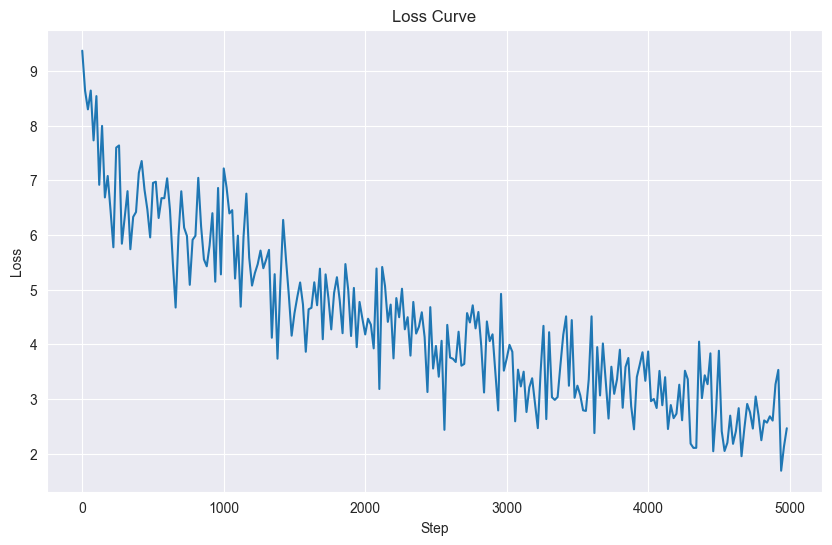

In [381]:
plot_loss(history)

In [382]:
test_model(model1, tokenizer, ["n", "l", "p"])

Entrada: n - l - p
Saída: 14 - 16 - 16 - <eos>


Como dito na questão 1, o mapa de atenção será plotado apenas uma vez , visto que teriamos os mesmos resultados para os dois modelos em cada uma das questões, para as questões 3 e 4 plotaremos a atenção para cada modelo.

#### Alfabeto até F (modelo 2)

In [383]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [384]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=64, out_features=9, bias=True)
)

In [385]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.6395
Epoch 250/5000, Loss: 1.7975
Epoch 500/5000, Loss: 0.6817
Epoch 750/5000, Loss: 0.5881
Epoch 1000/5000, Loss: 0.3857
Epoch 1250/5000, Loss: 1.3952
Epoch 1500/5000, Loss: 0.1926
Epoch 1750/5000, Loss: 0.0686
Epoch 2000/5000, Loss: 3.2489
Epoch 2250/5000, Loss: 0.0457
Epoch 2500/5000, Loss: 0.6991
Epoch 2750/5000, Loss: 0.6575
Epoch 3000/5000, Loss: 0.0458
Epoch 3250/5000, Loss: 0.0283
Epoch 3500/5000, Loss: 0.4947
Epoch 3750/5000, Loss: 0.1703
Epoch 4000/5000, Loss: 1.0196
Epoch 4250/5000, Loss: 0.0034
Epoch 4500/5000, Loss: 0.0108
Epoch 4750/5000, Loss: 0.0555


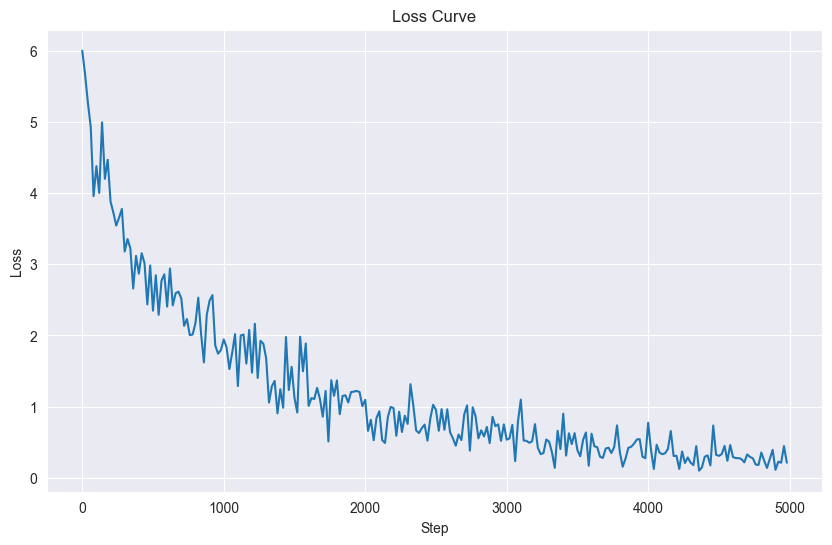

In [386]:
plot_loss(history)

In [387]:
test_model(model2, tokenizer, ["a", "b", "c"])

Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


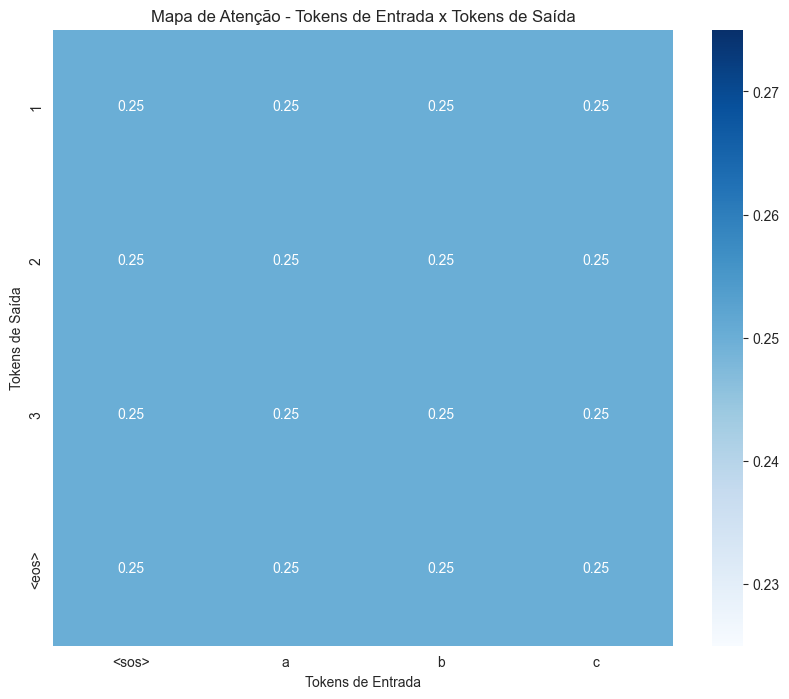

In [388]:
plot_attention(model2, tokenizer, input=["a", "b", "c"])

#### **Questão 3**

Implemente o mecanismo de atenção de  Bahdanau et al. (2015). Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

**Comentario**

Como haviamos comentado na questão 1, agora há a necessidade de que em cada passo do decoder possamos ter acesso aos hiddens do encoder, pois para cada entrada, teremos diferentes scores de atenção, diferente das implementações anteriores. Com isso, precisamos salvar os hiddens do encoder para cada timestep, e calcular o attention score para cada timestep do decoder. Com isso, passamos a salvar não mais o vetor de atenção de maneira estática para todos os steps, mas salvamos os hiddens do encoder e calculamos o attention score para cada hidden do decoder. O cálculo da atenção é feito da seguinte forma:

1. Para cada hidden do decoder, calculamos o produto interno desse hidden com cada hidden do encoder e salvamos isso em um vetor.
2. Passamos esse vetor pela função softmax para obter os pesos do attention.
3. Para cada hidden do encoder e seu respectivo score de attention, multiplicamos o hidden pelo peso do attention, e somamos todos esses vetores para obter o vetor de attention.

Com isso, propagamos esse vetor no decoder utilizando o use_attention fornecido na implementação do decoder, e seguir o fluxo.


In [612]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        
        self.hiddens_encoder = [] #inicialização dos hiddens do decoder
        
        self.attention_scores = []
        

    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.hiddens_encoder = encoder_hidden_states


        self.attention_scores = []
        hidden_decoder = decoder_hidden_state[-1] # Pegamos o hidden da última camada do decoder
        
        for i in range(len(self.hiddens_encoder)): # Para cada vetor no hidden
            hidden_encoder = self.hiddens_encoder[i]
            attention_score = torch.dot(hidden_decoder, hidden_encoder) # Calcula o attention score como produto interno do hidden_encoder e hidden_decoder
            self.attention_scores.append(attention_score)
            
        self.attention_scores = F.softmax(torch.stack(self.attention_scores), dim=0) # Softmax para obter os pesos do attention
        
        attention_vec = torch.sum((self.attention_scores.unsqueeze(1) * self.hiddens_encoder), dim=0).unsqueeze(0) # Multiplica os pesos do attention com os hiddens do encoder e soma todos


        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [628]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [639]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=29, bias=True)
)

In [640]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.5438
Epoch 250/5000, Loss: 10.3175
Epoch 500/5000, Loss: 2.8165
Epoch 750/5000, Loss: 8.5315
Epoch 1000/5000, Loss: 8.0718
Epoch 1250/5000, Loss: 2.0743
Epoch 1500/5000, Loss: 2.9592
Epoch 1750/5000, Loss: 6.0578
Epoch 2000/5000, Loss: 2.4823
Epoch 2250/5000, Loss: 10.6690
Epoch 2500/5000, Loss: 1.0395
Epoch 2750/5000, Loss: 10.1434
Epoch 3000/5000, Loss: 5.7353
Epoch 3250/5000, Loss: 1.5353
Epoch 3500/5000, Loss: 2.4299
Epoch 3750/5000, Loss: 1.7085
Epoch 4000/5000, Loss: 4.8622
Epoch 4250/5000, Loss: 7.6694
Epoch 4500/5000, Loss: 3.2714
Epoch 4750/5000, Loss: 1.4027


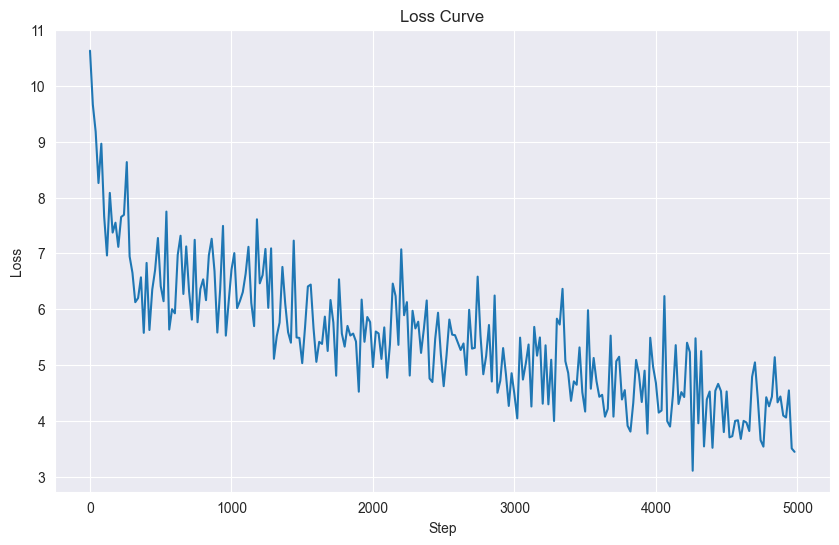

In [641]:
plot_loss(history)

In [642]:
test_model(model1, tokenizer, ["n", "l", "p"])

Entrada: n - l - p
Saída: 14 - 1 - 16 - <eos>


Entrada: n - l - p
Saída: 14 - 1 - 16 - <eos>


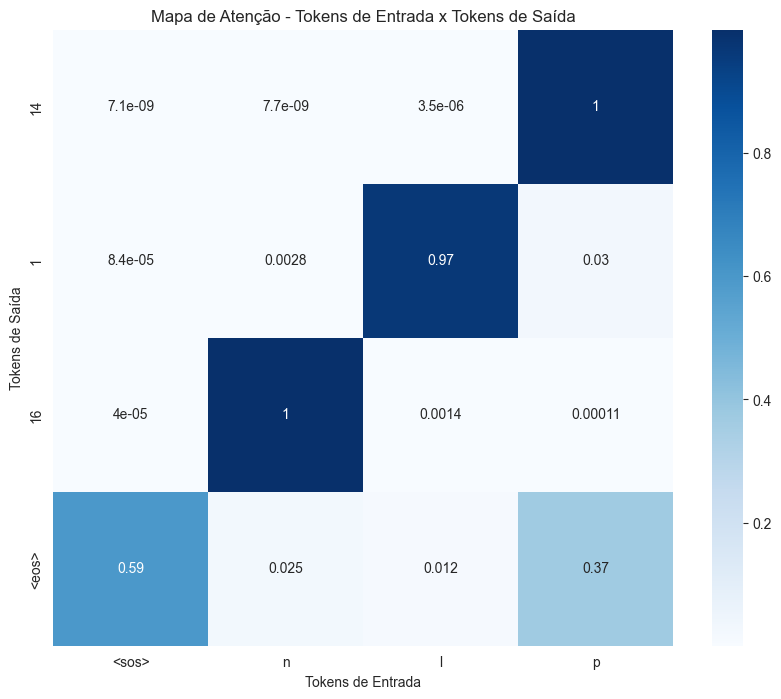

In [643]:
plot_attention(model1, tokenizer, input=["n", "l", "p"])

#### Alfabeto até F (modelo 2)

In [644]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [645]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=9, bias=True)
)

In [646]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 8.5359
Epoch 250/5000, Loss: 5.0170
Epoch 500/5000, Loss: 2.6114
Epoch 750/5000, Loss: 2.5074
Epoch 1000/5000, Loss: 3.3421
Epoch 1250/5000, Loss: 3.9527
Epoch 1500/5000, Loss: 2.7516
Epoch 1750/5000, Loss: 0.8884
Epoch 2000/5000, Loss: 2.5576
Epoch 2250/5000, Loss: 0.6290
Epoch 2500/5000, Loss: 2.9897
Epoch 2750/5000, Loss: 2.4764
Epoch 3000/5000, Loss: 0.3423
Epoch 3250/5000, Loss: 0.4493
Epoch 3500/5000, Loss: 0.2871
Epoch 3750/5000, Loss: 0.0696
Epoch 4000/5000, Loss: 0.1119
Epoch 4250/5000, Loss: 2.1595
Epoch 4500/5000, Loss: 0.1658
Epoch 4750/5000, Loss: 0.2612


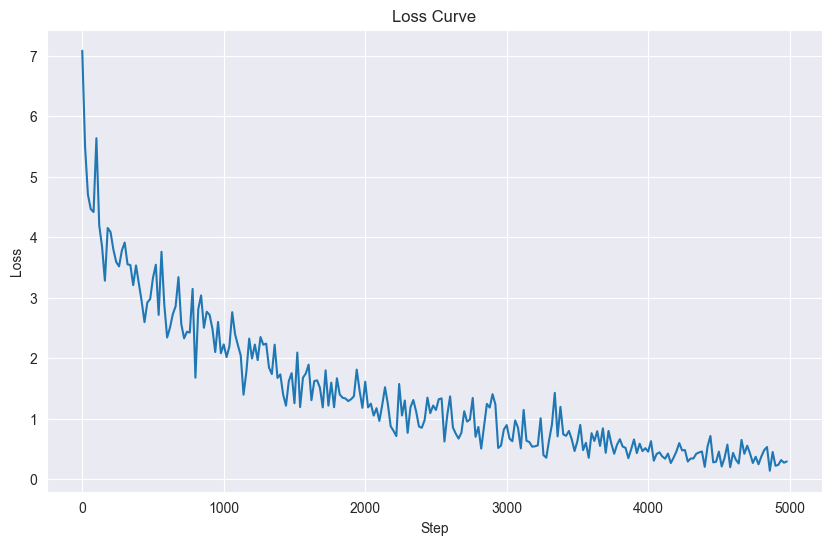

In [647]:
plot_loss(history)

In [648]:
test_model(model2, tokenizer, ["a", "b", "c"])

Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


#### **Mapa de atenção**

Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


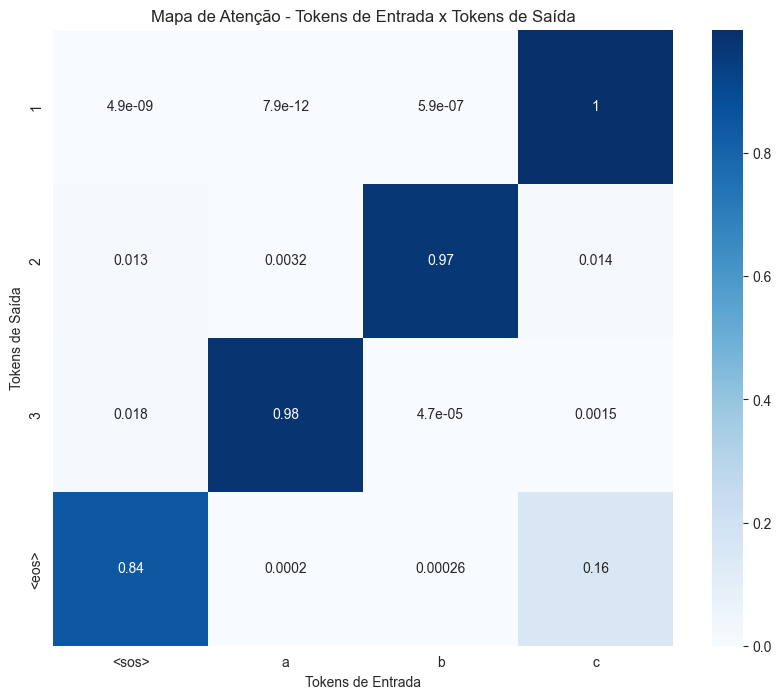

In [650]:
plot_attention(model2, tokenizer, input=["a", "b", "c"])

**Comentario**

Nesse caso percebemos que a atenção já varia para cada input, ainda assim não podemos aprender ela diretamente, dependemos de que as representações vetoriais aprendidas para os hiddens tornem essa atenção algo que faça "mais sentido". Outro detalhe é que temos vetores com scores muito altos, provavelmente, por que, os valores passados para a softmax tenham uma diferença "em modulo" alta, para mitigar esse efeito poderiamos passar por uma função de ativação ou até mesmo dividir os vetores pela raiz do tamanho do `hidden_state`. Vamos testar essa hipótese.


In [651]:
'''TESTE PARA VERIFICAR'''

class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)

        self.hiddens_encoder = [] #inicialização dos hiddens do decoder

        self.attention_scores = []


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.hiddens_encoder = encoder_hidden_states


        self.attention_scores = []
        hidden_decoder = decoder_hidden_state[-1] # Pegamos o hidden da última camada do decoder

        for i in range(len(self.hiddens_encoder)): # Para cada vetor no hidden
            hidden_encoder = self.hiddens_encoder[i]
            attention_score = torch.dot(hidden_decoder, hidden_encoder) / hidden_dim ** 0.5 # ADIÇÃO DE UMA "NORMALIZAÇÃO" ANTES DE PASSAR POR UMA SOFTMAX
            self.attention_scores.append(attention_score)

        self.attention_scores = F.softmax(torch.stack(self.attention_scores), dim=0) # Softmax para obter os pesos do attention

        attention_vec = torch.sum((self.attention_scores.unsqueeze(1) * self.hiddens_encoder), dim=0).unsqueeze(0) # Multiplica os pesos do attention com os hiddens do encoder e soma todos


        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)

        return output, hidden

In [652]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 9.4739
Epoch 250/5000, Loss: 5.2262
Epoch 500/5000, Loss: 3.8454
Epoch 750/5000, Loss: 0.3197
Epoch 1000/5000, Loss: 0.2927
Epoch 1250/5000, Loss: 0.2445
Epoch 1500/5000, Loss: 0.6939
Epoch 1750/5000, Loss: 0.1859
Epoch 2000/5000, Loss: 0.1286
Epoch 2250/5000, Loss: 0.1743
Epoch 2500/5000, Loss: 1.5009
Epoch 2750/5000, Loss: 0.0399
Epoch 3000/5000, Loss: 0.1962
Epoch 3250/5000, Loss: 0.3211
Epoch 3500/5000, Loss: 0.0611
Epoch 3750/5000, Loss: 0.4393
Epoch 4000/5000, Loss: 0.2658
Epoch 4250/5000, Loss: 0.1418
Epoch 4500/5000, Loss: 0.0034
Epoch 4750/5000, Loss: 0.1043


Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


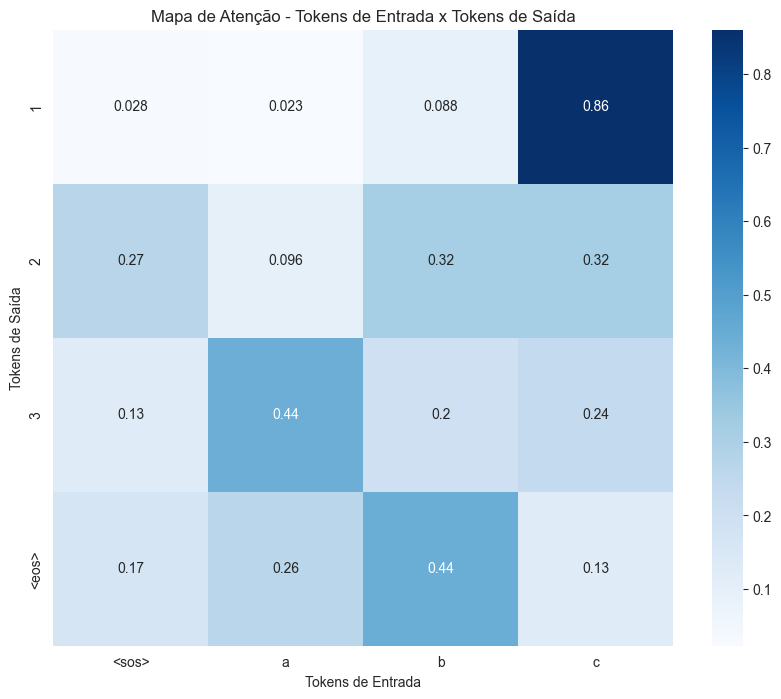

In [653]:
plot_attention(model1, tokenizer, input=["a", "b", "c"])

Agora é possível perceber que temos valores de atenção mais "equilibrados", ainda assim, Como dito anteriormente, os valorres de atenção dependem do quao bem os hiddens estão sendo calculados, e não tem pesos aprendivies, o aprendizado é "indireto", onde dado um attention, corrigimos as representações vetoriais (hiddens).

#### **Questão 4**
Implemente a "??? Attention" apresentada durante a aula.  Após isso, treine dois modelos com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

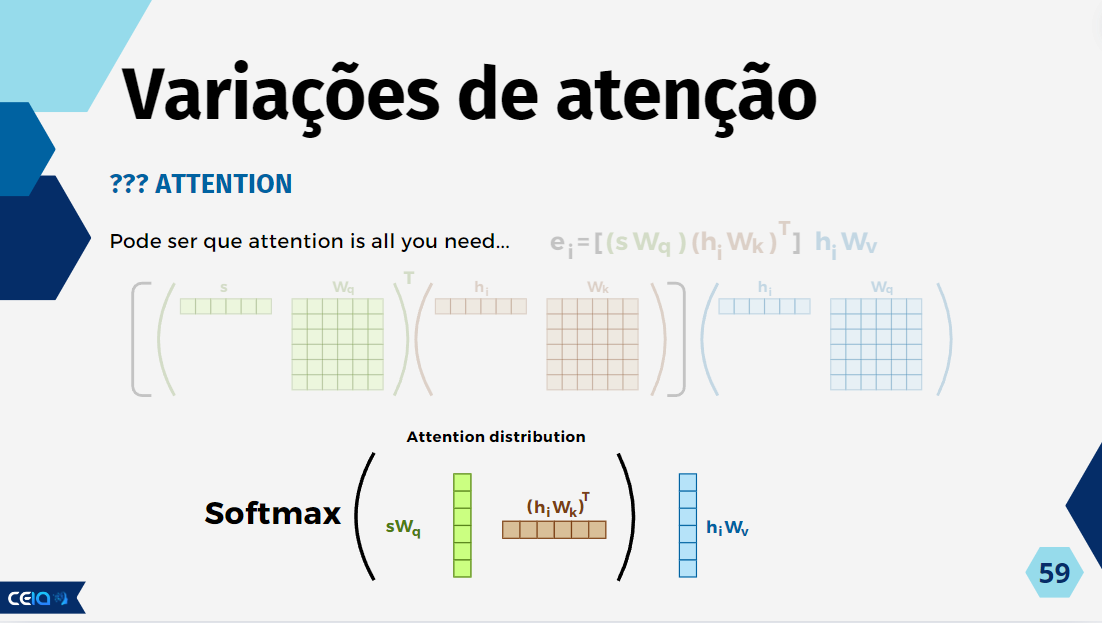

**Comentario**

Para a ??? Attention temos uma propriedade interessante inserida, a de que possuímos vetores de query, key e value. Onde, um dos grandes ganhos é que esses vetores são aprendidos pela rede.
Para a implementação, temos a seguinte metodologia:

1. Inicializamos q, k e v como Lineares, onde entramos com o hidden e saimos com um vetor de tamanho igual, ou seja, temos um peso para cada número do vetor em cada representação.
2. Calculamos o score de atenção, que é o produto escalar entre q e k. (o vetor de q representa a query, enquanto o vetor de k representa a key, por isso, passamos para q o hidden do decoder e para k os hiddens do encoder)
3. Aplicamos uma softmax para obter os pesos de atenção.
4. Multiplicamos os pesos de atenção com os respectivos values e somamos, obtendo assim o vetor de atenção.

Como os pesos que geram a atenção são aprendíveis de maneira direta, espero que com essa implementação a atenção faça mais sentido


In [654]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        
        self.q = nn.Linear(hidden_dim, hidden_dim)
        self.k = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, hidden_dim)

        self.hiddens_decoder = [] #inicialização dos hiddens do decoder

        self.attention_scores = []



    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.hiddens_decoder = encoder_hidden_states


        self.attention_scores = []
        hidden_decoder = decoder_hidden_state[-1] # Pegamos o hidden da última camada do decoder

        for i in range(len(self.hiddens_decoder)): # Para cada vetor no hidden
            
            q_vector = self.q(hidden_decoder)
            k_vector = self.k(self.hiddens_decoder[i])
            
            attention_score = torch.dot(q_vector, k_vector)
            self.attention_scores.append(attention_score)
            

        self.attention_scores = F.softmax(torch.stack(self.attention_scores), dim=0) # Softmax para obter os pesos do attention

        attention_vec = torch.sum(self.attention_scores.unsqueeze(1) * self.v(self.hiddens_decoder), dim=0).unsqueeze(0) # Multiplica os pesos do attention com os hiddens do encoder


        
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [655]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [656]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(29, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=29, bias=True)
  (q): Linear(in_features=32, out_features=32, bias=True)
  (k): Linear(in_features=32, out_features=32, bias=True)
  (v): Linear(in_features=32, out_features=32, bias=True)
)

In [657]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 5.9975
Epoch 250/5000, Loss: 3.4267
Epoch 500/5000, Loss: 6.4745
Epoch 750/5000, Loss: 6.1286
Epoch 1000/5000, Loss: 5.6823
Epoch 1250/5000, Loss: 8.4811
Epoch 1500/5000, Loss: 10.2779
Epoch 1750/5000, Loss: 8.7212
Epoch 2000/5000, Loss: 2.1799
Epoch 2250/5000, Loss: 3.8090
Epoch 2500/5000, Loss: 5.7082
Epoch 2750/5000, Loss: 1.7604
Epoch 3000/5000, Loss: 1.4264
Epoch 3250/5000, Loss: 5.7860
Epoch 3500/5000, Loss: 5.0767
Epoch 3750/5000, Loss: 2.2500
Epoch 4000/5000, Loss: 4.9249
Epoch 4250/5000, Loss: 1.6460
Epoch 4500/5000, Loss: 1.2531
Epoch 4750/5000, Loss: 3.0503


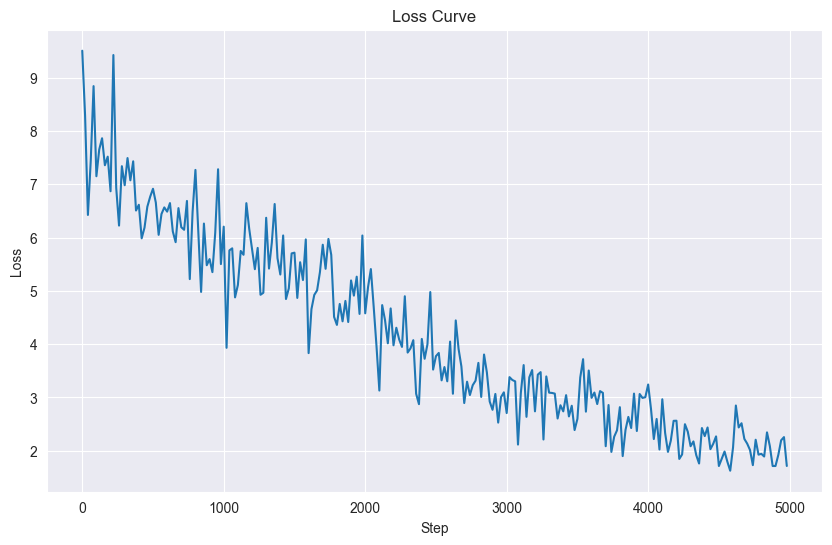

In [658]:
plot_loss(history)

In [659]:
test_model(model1, tokenizer, ["n", "l", "p"])

Entrada: n - l - p
Saída: 14 - 12 - 16 - <eos>


Entrada: n - l - p
Saída: 14 - 12 - 16 - <eos>


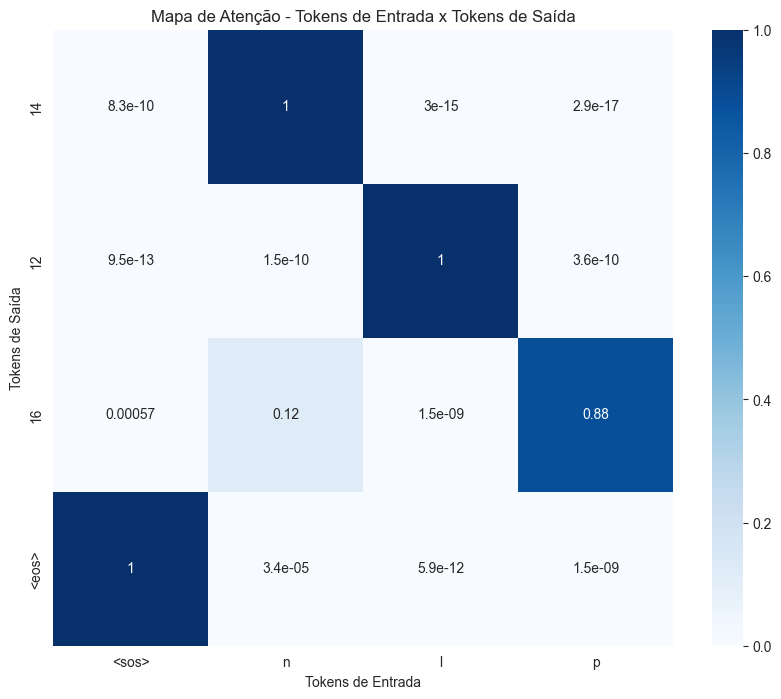

In [662]:
plot_attention(model1, tokenizer, ["n", "l", "p"])

Não só o modelo acertou toda representação pela primeira vez, como nos plotou um mapa de atenção MUITO INTERESSANTE, vamos discutir sobre mais a frente.

##### Alfabeto até a letra "f" (modelo 2)

In [669]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [670]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 10000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=9, bias=True)
  (q): Linear(in_features=32, out_features=32, bias=True)
  (k): Linear(in_features=32, out_features=32, bias=True)
  (v): Linear(in_features=32, out_features=32, bias=True)
)

In [671]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

Epoch 0/10000, Loss: 3.7779
Epoch 250/10000, Loss: 1.8356
Epoch 500/10000, Loss: 5.2801
Epoch 750/10000, Loss: 0.1158
Epoch 1000/10000, Loss: 0.7854
Epoch 1250/10000, Loss: 0.3042
Epoch 1500/10000, Loss: 0.0358
Epoch 1750/10000, Loss: 0.0262
Epoch 2000/10000, Loss: 0.0161
Epoch 2250/10000, Loss: 0.2310
Epoch 2500/10000, Loss: 0.0166
Epoch 2750/10000, Loss: 0.0310
Epoch 3000/10000, Loss: 0.0080
Epoch 3250/10000, Loss: 0.0311
Epoch 3500/10000, Loss: 0.0372
Epoch 3750/10000, Loss: 0.0674
Epoch 4000/10000, Loss: 0.0117
Epoch 4250/10000, Loss: 0.0060
Epoch 4500/10000, Loss: 0.0066
Epoch 4750/10000, Loss: 0.0044
Epoch 5000/10000, Loss: 0.0029
Epoch 5250/10000, Loss: 0.0067
Epoch 5500/10000, Loss: 0.0028
Epoch 5750/10000, Loss: 0.0076
Epoch 6000/10000, Loss: 0.0026
Epoch 6250/10000, Loss: 0.0043
Epoch 6500/10000, Loss: 0.4867
Epoch 6750/10000, Loss: 0.0084
Epoch 7000/10000, Loss: 0.0038
Epoch 7250/10000, Loss: 0.0330
Epoch 7500/10000, Loss: 0.0047
Epoch 7750/10000, Loss: 0.0015
Epoch 8000/100

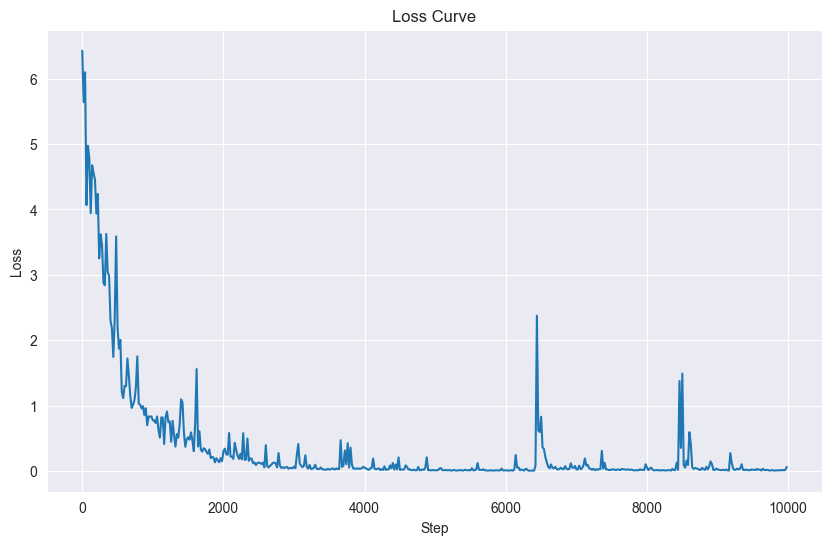

In [672]:
plot_loss(history)

In [673]:
test_model(model2, tokenizer, ["d", "b", "c"])

Entrada: d - b - c
Saída: 4 - 2 - 3 - <eos>


Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


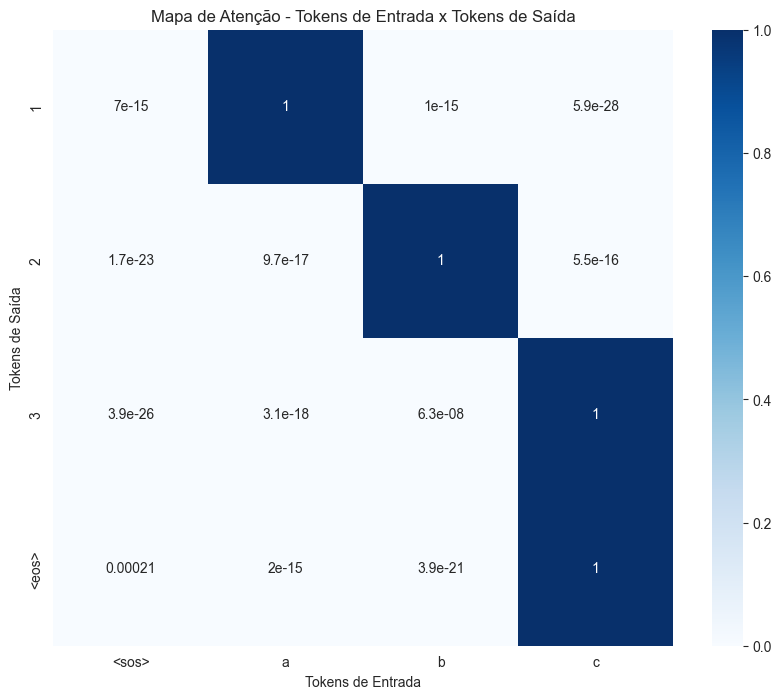

In [674]:
plot_attention(model2, tokenizer, ["a", "b", "c"])

Nesse caso, podemos observar que para cada token previsto pela rede a atenção estava em cima exatamente do seu correspondente de entrada no encoder, uma das suposições a reespeito é justamente por termos valores aprendiveis para gerar essa atenção, com um grau de liberdade alto, dado que possuimos 3 matrizes, querys, keys e values. Ainda na próxima questão exploraremos um pouco mais a divisão do valor de score antes de passar pela softmax.

#### **Questão 5**
A partir das suas descobertas nas Questões 3 e 4,  explore a criação de duas novas classes: "class BahdanauAttention" (com a atenção de Bahdanau) e "class WhatAttention" (com a ??? Attention). Após criá-las, adicione à classe Seq2Seq. Insira um novo parâmetro na classe Seq2Seq para permitir escolher qual attention deve-se utilizar (attention_implementation="bahdanau" para atenção de Bahdanau ou attention_implementation="qkv_attention" para ??? Attention)

> Dica: Observe a criação das classes Encoder e Decoder e como foram inseridas dentro da classe Seq2Seq

Para essa questão a metodologia aplicada foi se basear nas atenções previamente implementadas, e adaptar para as classes. A ideia era que a classe fosse responsável por calcular o score de atenção e o vetor de atenção, enquanto a classe Seq2Seq seria responsável por chamar a atenção e passar para o decoder.

In [683]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
    
        
    def forward(self, hidden, encoder_outputs):
        attention_scores = []
        
        for i in range(len(encoder_outputs)):
            attention_score = torch.dot(hidden, encoder_outputs[i])
            attention_scores.append(attention_score)
            
        attention_scores = F.softmax(torch.stack(attention_scores), dim=0) 
        
        attention_vec = torch.sum(attention_scores.unsqueeze(1) * encoder_outputs, dim=0).unsqueeze(0) # Multiplicação ponto a ponto (produto interno
        
        return attention_vec, attention_scores


Na implementação da WhatAttention, aplicamos um fator para dividr os socres antes da softmax, para tentar evitar o problema de valores muito altos, vamos ver o resultado.

In [684]:
class WhatAttention(nn.Module):
    def __init__(self, hidden_size):
        super(WhatAttention, self).__init__()
        self.hidden_size = hidden_size
        
        self.q = nn.Linear(hidden_size, hidden_size)
        self.k = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, hidden_size)
        self.dk = hidden_size ** 0.5
        
    def forward(self, hidden, encoder_outputs):
        attention_scores = []
        
        for i in range(len(encoder_outputs)):
            q_vector = self.q(hidden)
            k_vector = self.k(encoder_outputs[i])
            
            attention_score = torch.dot(q_vector, k_vector) / self.dk
            attention_scores.append(attention_score)
            
        attention_scores = F.softmax(torch.stack(attention_scores), dim=0)
        
        attention_vec = torch.sum(attention_scores.unsqueeze(1) * self.v(encoder_outputs), dim=0).unsqueeze(0)
        
        return attention_vec, attention_scores

In [685]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, attention_implementation="qkv_attention", sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.encoder_hidden_states = []
        
        self.attention_scores = []
        
        if attention_implementation == "bahdanau":
            self.attention = BahdanauAttention(hidden_dim)
        elif attention_implementation == "qkv_attention":
            self.attention = WhatAttention(hidden_dim)
        else:
            raise ValueError("Invalid attention implementation")
        
    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.encoder_hidden_states = encoder_hidden_states
        
        hidden_decoder = decoder_hidden_state[-1]
        
        attention_vec, attention_scores = self.attention(hidden_decoder, self.encoder_hidden_states)
        
        self.attention_scores = attention_scores
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)
        
        return output, hidden

In [686]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [687]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, attention_implementation='qkv_attention')
model1

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(32, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 32)
    (rnn): RNN(64, 32, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=32, out_features=9, bias=True)
  (attention): WhatAttention(
    (q): Linear(in_features=32, out_features=32, bias=True)
    (k): Linear(in_features=32, out_features=32, bias=True)
    (v): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [688]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 9.3800
Epoch 250/5000, Loss: 2.1725
Epoch 500/5000, Loss: 2.8826
Epoch 750/5000, Loss: 4.6381
Epoch 1000/5000, Loss: 0.5985
Epoch 1250/5000, Loss: 0.3292
Epoch 1500/5000, Loss: 1.5067
Epoch 1750/5000, Loss: 0.1117
Epoch 2000/5000, Loss: 0.2421
Epoch 2250/5000, Loss: 0.2823
Epoch 2500/5000, Loss: 0.0326
Epoch 2750/5000, Loss: 0.0902
Epoch 3000/5000, Loss: 0.0658
Epoch 3250/5000, Loss: 0.1314
Epoch 3500/5000, Loss: 0.0115
Epoch 3750/5000, Loss: 0.0062
Epoch 4000/5000, Loss: 0.0282
Epoch 4250/5000, Loss: 0.0215
Epoch 4500/5000, Loss: 0.0104
Epoch 4750/5000, Loss: 0.0075


In [689]:
test_model(model1, tokenizer, ["d", "b", "c"])

Entrada: d - b - c
Saída: 4 - 2 - 3 - <eos>


Entrada: d - b - c
Saída: 4 - 2 - 3 - <eos>


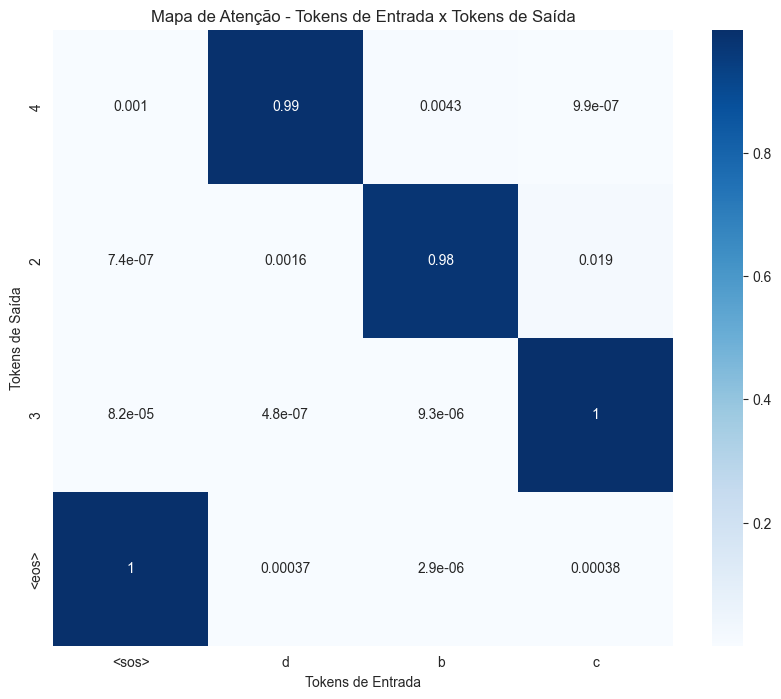

In [691]:
plot_attention(model1, tokenizer, ["d", "b", "c"])

Mesmo utilizando a "normalização" antes de passar a softmax os valores de atenção ainda estavam concentrados no token correspondente. Com isso nos surge a seguinte dúvida, visualizar a atenção conforme o aprendizado, como ficaria?

Epoch 0/200, Loss: 4.1145
Epoch 0/200, Loss: 1.4180
Entrada: a - b - c
Saída: 6 - 4 - 4 - <eos>


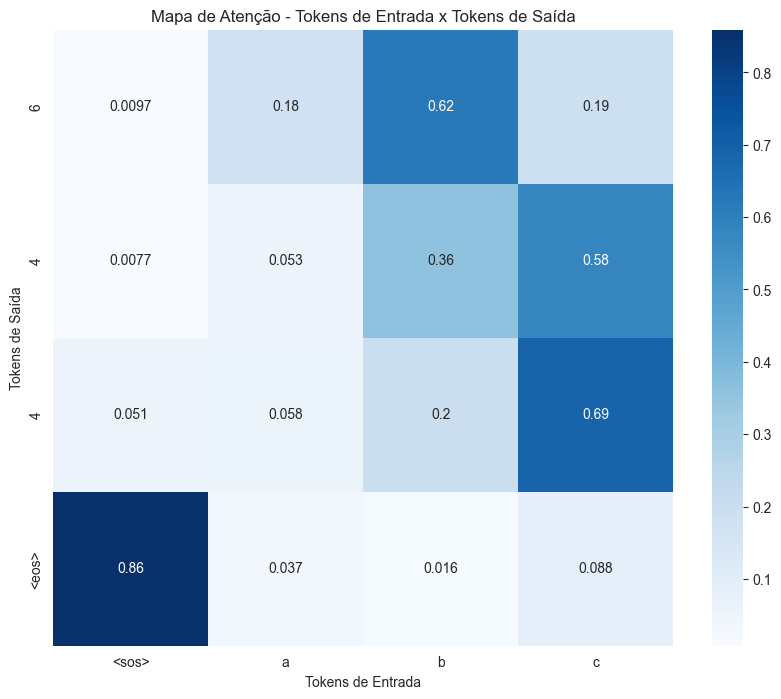

Epoch 0/200, Loss: 2.5601
Entrada: a - b - c
Saída: 1 - 2 - 1 - <eos>


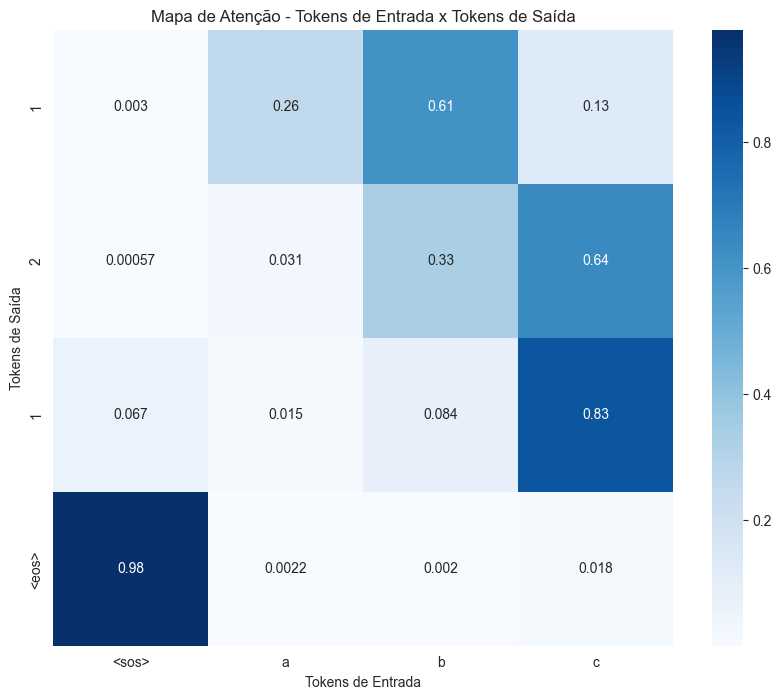

Epoch 0/200, Loss: 3.5043
Entrada: a - b - c
Saída: 1 - 3 - 4 - <eos>


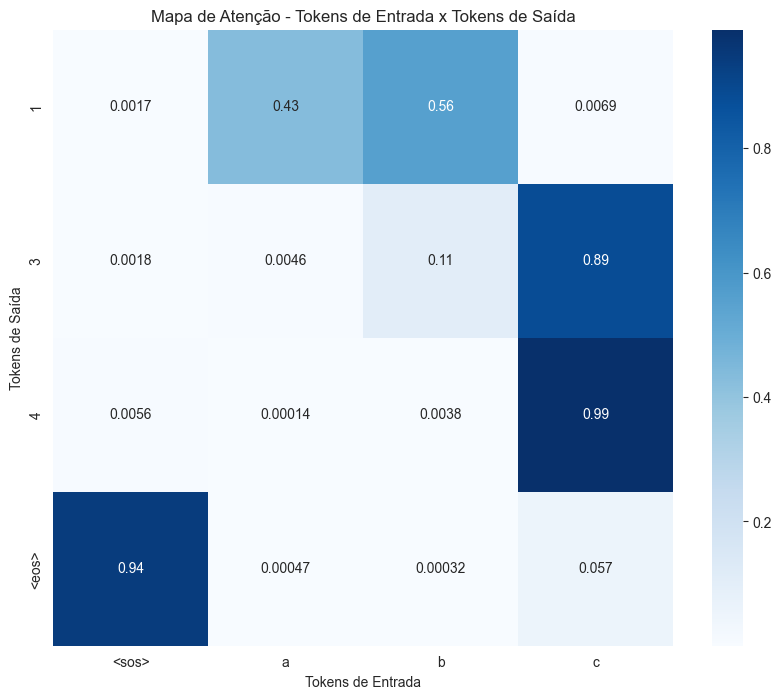

Epoch 0/200, Loss: 2.5743
Entrada: a - b - c
Saída: 1 - 1 - 3 - <eos>


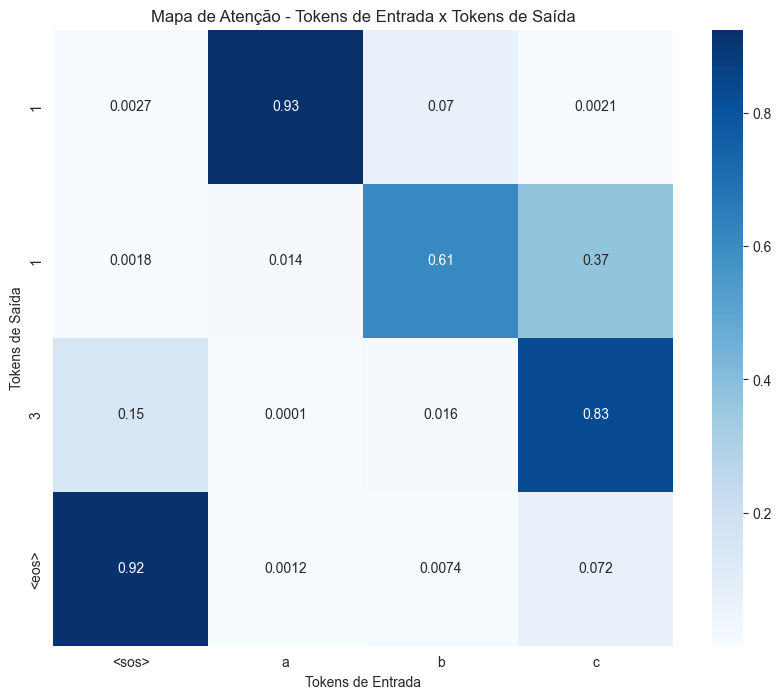

Epoch 0/200, Loss: 0.6126
Entrada: a - b - c
Saída: 1 - 2 - 3 - <eos>


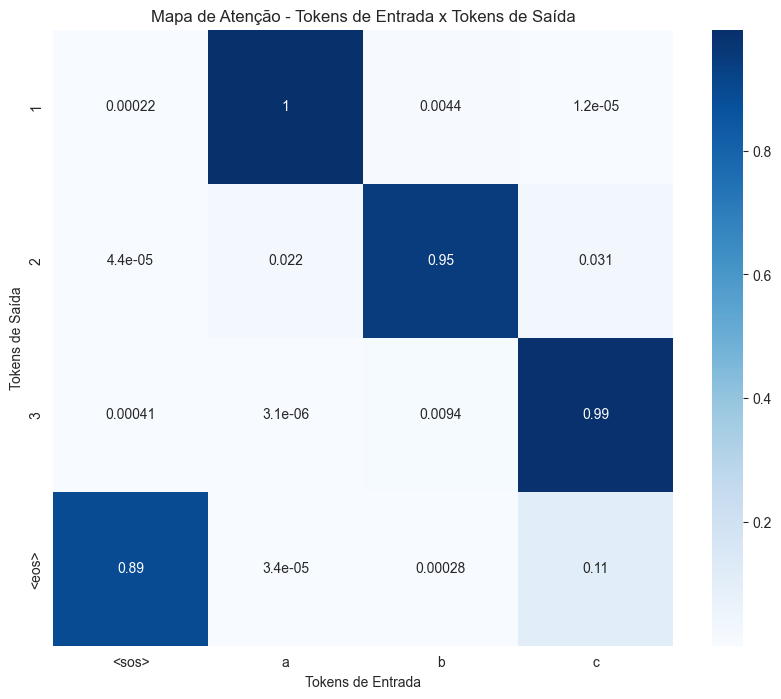

In [482]:
n_views = 5

emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 200

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)


for i in range(n_views):
    history = train(model1, tokenizer, criterion, optimizer, num_steps)
    plot_attention(model1, tokenizer, ["a", "b", "c"])

Uau, podemos ver a atenção sendo aprendida ao longo das épocas. 

#### **Comentários finais**

- Relate aqui seus achados, dificuldades encontradas durante o processo, percepções sobre o tema, e demais comentários que gostaria de realizar.

Comentários: Os comentários, percepções e dificuldades encontradas durante o processo foram documentados ao decorrer do notebook, para estabaelecer uma linha de raciocínio. Contuso, uma dúvida surgiu, os modelos de geração de embeddings dos tokens não deveriam ser separados do encoder/decoder? Do jeito que está implementado, para cada step desses teríamos embeddings diferentes na representação, pensei que os pesos que formam esse embedding deveriam ser "abstraidos" a nível de modelo, não de etapa (encoder/decoder).

Além disso, não foi modificado alguma classe diferente da seq2seq 